# COMP - 4301 Final Project - Path Detection using Object Detection in Video/Images
## Authors:
- Yaksh J Haranwala (201907532)
- Abdul Shaji
- Salman Haidri (2019065620 ?correct if wrong)
- Mohammed Shoaib (201952389)

## Beginning Notes:
- At the moment, I am planning to use this notebook as a centralized code file, since it is easier to code and debug in jupyter notebooks.
- As each of the below described code chunks get completed, the plan is to move them to separate .py modules as we go.
- This will allow for better, modular and understandable code.
- Finally, we will create a runner file that orchestrates the running of the entire module.


## File Descriptions:
- Object Detection (To be put in a separate .py file):
    - Using the PyTorch/Tensorflow framework, evaluate multiple pre-trained networks we have.
    - Choose the best one (fastest and with much higher prediction accuracy) to use as the model.
    - I think this is the right place to draw bounding boxes as well (if we want to).
    - Reference: https://kananvyas.medium.com/obstacle-detection-and-navigation-through-tensorflow-api-943728c33243

- Video Input Module (To be put in a separate .py file):
    - Currently, we are starting with image object detection.
    - However, I am planning it to expand it to live video feed either captured from webcam or by connecting a mobile device to the laptop (there must be some examples available).
    - This module will capture the video feed and send it to the object detection module to analyze.

- Distance calculation module (To be put in a separate .py file):
    - This module will be used to calculate the distance between 2 objects in the image/video to make sure that the guided object can pass between them without any issues.
    - We will simplify this by considering the object to be guided in our project to be a rectangle to make the calculation easier.

- Runner Module (To be put in a separate .py file):
    - This is the conductor file which performs error handling and stuff to make sure that the program, if crashes then it does so gracefully.

### A few notes:
- Document the code as much as possible.
- PLEASE get a citation of the code if you got even a chunk of it from somewhere and put it in the comments with the associated code.

In [1]:
# The ssd code is taken from: https://github.com/amdegroot/ssd.pytorch
# Furthermore, the loading of data, weights and training data is also taken from the same repo.
import numpy as np
import cv2 as cv
import torch
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch.nn as nn

from ssd.ssd import build_ssd

import warnings
warnings.simplefilter("ignore", category=UserWarning)

In [2]:
net = build_ssd('test')
net.load_weights('./ssd300_mAP_77.43_v2.pth')

Loading weights into state dict...
Finished!


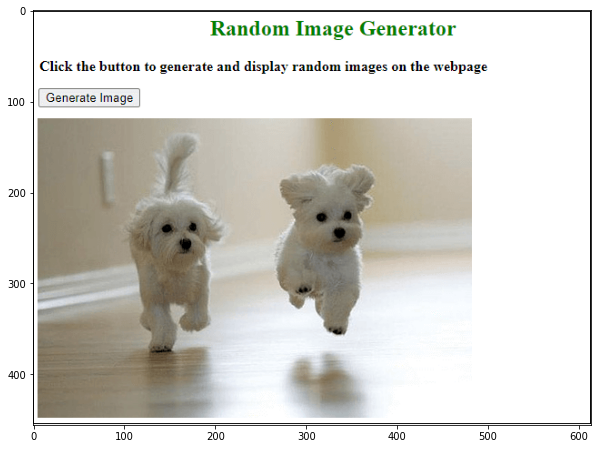

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from ssd.data import COCODetection, COCO_ROOT, COCOAnnotationTransform

# here we specify year (07 or 12) and dataset ('test', 'val', 'train')
image = cv.imread('./test_img/random.png')
# image = cv.imread('./images/dog4x-nn.png')
rgb_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


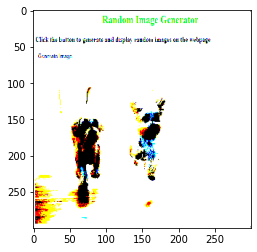

In [4]:
x = cv.resize(image, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
plt.imshow(x)
x = torch.from_numpy(x).permute(2, 0, 1)

In [5]:
xx = Variable(x.unsqueeze(0))
y = net(xx)

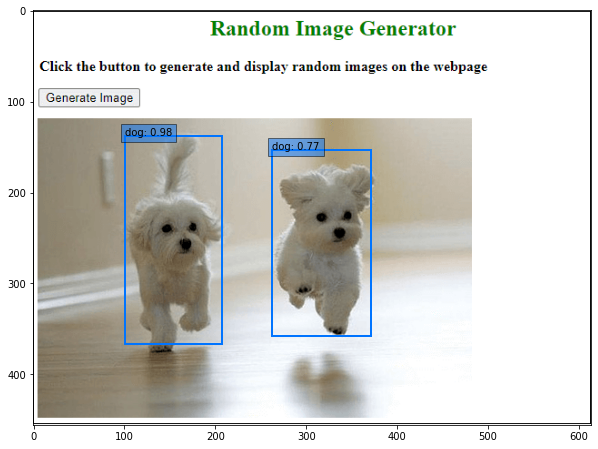

In [6]:
from ssd.data import VOC_CLASSES as l1
from ssd.data import COCO_CLASSES as l2
top_k=10

labels = l1 + l2

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1
